In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from libpysal import weights

The data consist of 6 months of hourly measered NO2 concentrations at 11 measuring points in the mid of london. 

In [3]:
laqn = pd.read_csv("data/londonNO2.csv")

In [4]:
laqn

,Unnamed: 0,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,lat,lon
0,0,BL0,NO,2021-01-03 00:00:00,6.2,ug m-3,R,51.522287,-0.125848
1,1,BL0,NO,2021-01-03 01:00:00,1.8,ug m-3,R,51.522287,-0.125848
2,2,BL0,NO,2021-01-03 02:00:00,1.7,ug m-3,R,51.522287,-0.125848
3,3,BL0,NO,2021-01-03 03:00:00,1.3,ug m-3,R,51.522287,-0.125848
4,4,BL0,NO,2021-01-03 04:00:00,1.9,ug m-3,R,51.522287,-0.125848
...,...,...,...,...,...,...,...,...,...
48571,26491,HK6,NOX,2021-08-31 19:00:00,17.6,ug m-3 as NO2,R,51.526454,-0.084910
48572,26492,HK6,NOX,2021-08-31 20:00:00,15.2,ug m-3 as NO2,R,51.526454,-0.084910
48573,26493,HK6,NOX,2021-08-31 21:00:00,15.2,ug m-3 as NO2,R,51.526454,-0.084910
48574,26494,HK6,NOX,2021-08-31 22:00:00,15.8,ug m-3 as NO2,R,51.526454,-0.084910


We convert our data to a GeoDataFrame, so we can exploit the positions from the points to build a Graph with networkx.

In [6]:
laqn=gpd.GeoDataFrame(laqn, geometry=gpd.points_from_xy(laqn.lon,laqn.lat),crs="EPSG:4326")

With the help of libpysal, we estimate the distance between the points, which indicates the strength of the relationship between two nodes. For this, we just have to specify one value per node. Then we convert the distance to a graph.

In [7]:
kernel_distance = weights.Kernel.from_dataframe(laqn.groupby("Site").first())
kernel_graph = kernel_distance.to_networkx()

We can now look at the created edges.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

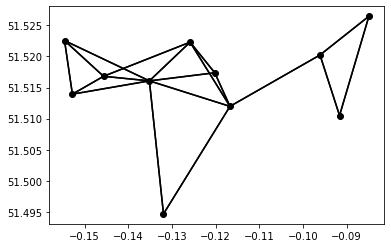

In [8]:
kernel_distance.plot(laqn.groupby("Site").first())

### Constructing the Data Iterator

In [9]:
import torch
from torch_geometric_temporal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

With torch_geometric_temporal we can construct a data iterator, which we will use later when we train our Graph Neural Network. In our case we have 11 fixed points, so we have a static graph. But our signal is temporal, so we have to construct a StaticGraphTemporalSignal. For that we need 4 things.

* edge_index: An array with the source and target nodes of all edegs in the graph
* edge_weight: An array with the weights of the edges
* features: A list of arrays, with the features of each node
* targets: A list of arrays, with the target variable for each node

Let's start with the edge_index. With the graph defined as a networkx object, we can extract the edges like this.

In [10]:
edges = np.array(kernel_graph.edges).tolist()

However for constructing the final array, we need to account for both directions of an edge. So we define our edges of one direction. The we flip each pair of our original edges, which gives us the edges of the other direction.

In [11]:
edges1 = torch.tensor(np.array(edges),dtype=torch.long)
edges2 = torch.tensor(np.array(edges),dtype=torch.long).flip(dims=[1])

Now we filter the selfloops, since they have not two directions.

In [12]:
edges2 = edges2.tolist()
edges2 = torch.tensor([val for val in edges2 if val[0]!=val[1]])

Then we concatenate the edge tensors and construct the edge_index object with the transpose.

In [13]:
edges = torch.cat((edges1, edges2),0)
edge_index = edges.t().contiguous()

Now we head on with the weights of our edges. For this we first extract the weights with the affiliated function and then we flatten the list.

In [14]:
kernel_distance.weights.values()

weights = [val for sublist in kernel_distance.weights.values() for val in sublist]

In [15]:
edge_weight = np.array(weights)

For the targets we arange our dataframe, so that we can then extract the target value for every time point and node.

In [16]:
targets = laqn[["ReadingDateTime","Value","Site"]].groupby(["ReadingDateTime"]).Value.apply(list).reset_index().Value.to_list()

In [17]:
def get_targets_and_features(lags, targets):

    stacked_target = np.stack(targets)
    standardized_target = (stacked_target - np.mean(stacked_target, axis=0)) / (
            np.std(stacked_target, axis=0) + 10 ** -10
        )
    features = [
            standardized_target[i : i + lags, :].T
            for i in range(standardized_target.shape[0] - lags)
        ]
    targets = [
            standardized_target[i + lags, :].T
            for i in range(standardized_target.shape[0] - lags)
        ]

    return features, targets

In [18]:
features = get_targets_and_features(2, targets)[0]
targets = get_targets_and_features(2, targets)[1]

Now we can define our data set.

In [19]:
dataset = StaticGraphTemporalSignal(edge_index, edge_weight, features, targets)

Then split the data in training and test data

In [20]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.4)

### PyTorch Geometric Temporal

In [23]:
import torch.nn.functional as F
# import torch_geometric_temporal.nn
from torch_geometric_temporal.nn import STConv, SpatioTemporalAttention, GConvGRU

Now we can define our Graph Neural Network

In [24]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

And train it!

In [ ]:
model = RecurrentGCN(node_features=2, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in range(50):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()